In [7]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas.io.data as web
%matplotlib inline

In [4]:
# step 1: Range Selection
st = dt.datetime(2000,1,1)
en = dt.datetime(2013,1,1)
sp500_tickers_lil = ['AA','AAPL','ABC','ABT','ADBE','ADI','ADM','ADP','ADSK','AEE']
sp500_tickers_joey = ['AA','AAPL','ABC','ABT','ADBE','ADI','ADM','ADP','ADSK','AEE','AEP','AES','AET','AFL','AGN','AIG','AIV','AIZ','AKAM','ALL','AMAT','AMGN','AMP','AMT','AMZN','AN','ANTM','AON','APA','APC','APD','AVB','AVY','AXP','AZO','BA','BAC','BAX','BBBY','BBT','BBY','BCR','BDX','BEN','BHI','BIIB','BK','BLL','BMY','BRCM','BSX','BXP','C','CA','CAG','CAH','CAT','CB','CBG','CBS','CCE','CCL','CELG','CHK','CHRW','CI','CINF','CL','CLX','CMA','CMCSA','CME','CMI','CMS','CNP','CNX','COF','COH','COL','COP','COST','CPB','CSCO','CSX','CTAS','CTL','CTSH','CTXS','CVS','CVX','D','DD','DE','DFS','DGX','DHI','DHR','DIS','DOV','DOW','DRI','DTE','DUK','DVN','EA','EBAY','ECL','ED','EFX','EIX','EL','EMC','EMN','EMR','EOG','EQR','ESRX','ETFC','ETN','ETR','EXC','EXPD','EXPE','F','FCX','FDX','FE','FIS','FISV','FITB','FLR','FOXA','FTR','GAS','GD','GE','GILD','GIS','GLW','GME','GOOGL','GPC','GPS','GS','GT','GWW','HAL','HAR','HAS','HBAN','HD','HES','HIG','HOG','HON','HOT','HPQ','HRB','HST','HSY','HUM','IBM','ICE','IFF','INTC','INTU','IP','IPG','ITW','JCI','JEC','JNJ','JNPR','JPM','JWN','K','KEY','KIM','KLAC','KMB','KO','KR','KSS','L','LB','LEG','LEN','LH','LLL','LLTC','LLY','LM','LMT','LNC','LOW','LUK','LUV','M','MAR','MAS','MAT','MCD','MCHP','MCK','MCO','MDLZ','MDT','MET','MHFI','MKC','MMC','MMM','MO','MON','MRK','MRO','MS','MSFT','MSI','MTB','MU','MUR','MYL','NBL','NEE','NEM','NI','NKE','NOC','NOV','NSC','NTAP','NTRS','NUE','NVDA','NWL','OMC','ORCL','OXY','PAYX','PBI','PCAR','PCG','PCL','PCP','PDCO','PEG','PEP','PFE','PFG','PG','PGR','PH','PHM','PKI','PLD','PNC','PNW','POM','PPG','PPL','PRU','PSA','PX','QCOM','R','RAI','RF','RHI','RL','ROK','RRC','RTN','SBUX','SCHW','SE','SEE','SHW','SLB','SNA','SNDK','SO','SPG','SPLS','SRE','STI','STJ','STT','STZ','SWK','SYK','SYMC','SYY','T','TAP','TDC','TE','TGT','THC','TIF','TJX','TMK','TMO','TROW','TRV','TSN','TSO','TSS','TWX','TXN','TXT','UNH','UNM','UNP','UPS','USB','UTX','VAR','VFC','VIAB','VLO','VMC','VNO','VRSN','VZ','WAT','WBA','WFC','WFM','WHR','WM','WMB','WMT','WU','WY','WYN','XEL','XL','XLNX','XOM','XRX','YHOO','YUM','ZBH','ZION']

#options
jan = True

In [72]:
regr_coefs = []
k = 0

for ticker in sp500_tickers_joey:
    try:
        data = web.get_data_yahoo(ticker, start=st, end=en)
        k += 1
    except:
        print(ticker, "error")
        continue
        
    
    mdata = data.resample("M",how='last').pct_change().dropna()
    Y = mdata["Adj Close"].values - np.mean(mdata["Adj Close"].values)
    if jan:
        X = np.zeros([len(mdata["Adj Close"].values),16]) # 1 constant + 12*mo + 1 2y + 1 3y + January
        X[0::12,-1] = 1
    else:
        X = np.zeros([len(mdata["Adj Close"].values),15]) # 1 constant + 12*mo + 1 2y + 1 3y
    
    # constant
    X[:,-2] = 1
    
    X = pd.DataFrame(X)
    
    # monthly lags
    for x in range(12):
        X[x] = pd.Series(mdata["Adj Close"]).shift(1+x).values
    
    # 24m lags
    X[12] = pd.Series(mdata["Adj Close"]).shift(24).values
    
    # 36m lags
    X[13] = pd.Series(mdata["Adj Close"]).shift(36).values
    
    # truncate
    X = X.ix[36:]
    Y = pd.DataFrame(Y).ix[36:]
    
    
    #print("Ticker", ticker, "Regr. Start Date", mdata["Close"].index[36],"ndata",len(Y))
        
    result = sm.OLS(Y,X).fit()
    #print(result.summary())
    regr_coefs.append(result.params)
    
    '''
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(Y, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(Y, lags=40, ax=ax2)
    '''
    
#print("done")
avg_coefs = np.mean(np.array(regr_coefs),axis=0)
labels = ["1m","2m","3m","4m","5m","6m","7m","8m","9m","10m","11m","12m","24m","36m","const","Jan"]
for x in zip(labels, avg_coefs):
    print(x)

('1m', -0.10060336951050865)
('2m', -0.04646090585100697)
('3m', -0.039148532450012707)
('4m', -0.051681878472906742)
('5m', -0.024573592050105345)
('6m', -0.035499096200907201)
('7m', -0.074405553384210912)
('8m', 0.037950605435127974)
('9m', 0.04182284042087446)
('10m', -0.041514417764029844)
('11m', 0.049731158178113521)
('12m', -0.062613419313814575)
('24m', -0.0065865733315576434)
('36m', 0.024768369045317821)
('const', -0.0014942752035320926)
('Jan', 0.034550948063844261)


In [73]:
print(list(avg_coefs))

[-0.10060336951050865, -0.04646090585100697, -0.039148532450012707, -0.051681878472906742, -0.024573592050105345, -0.035499096200907201, -0.074405553384210912, 0.037950605435127974, 0.04182284042087446, -0.041514417764029844, 0.049731158178113521, -0.062613419313814575, -0.0065865733315576434, 0.024768369045317821, -0.0014942752035320926, 0.034550948063844261]


In [78]:
# Out of Sample Data
dataset = sp500_tickers_joey[:]

# take list of stocks
st = dt.datetime(2009,1,1)
en = dt.datetime(2016,1,1)
#ours
#regr_coef = np.array([0.25298567255645865, -0.12886536167593118, 0.019203996926985011, 0.028682508989952348, -0.0066884204332014778, -0.10153536136157984, 0.025687100756060847, -0.010705398522536751, -0.032641524657629657, -0.042552908843307105, 0.0042183541030977626, -0.044232746890859702, -0.030952224152683578, -0.014879969341961664, 0.0028323358461219473, -0.0060362359252851142])
# jegadeesh
#regr_coef = np.array([-.0923,-.0073,.0208,.0154,.0148,.0205,.0087,.0065,.0178,.0151,.0224,.0339,.0171,.0187,-.0033,.0135])
#regr_coef = -np.zeros(16)
#regr_coef = np.zeros(16)
#regr_coef[0] = 1
#ours recent
regr_coef = np.array([-0.10060336951050865, -0.04646090585100697, -0.039148532450012707, -0.051681878472906742, -0.024573592050105345, -0.035499096200907201, -0.074405553384210912, 0.037950605435127974, 0.04182284042087446, -0.041514417764029844, 0.049731158178113521, -0.062613419313814575, -0.0065865733315576434, 0.024768369045317821, -0.0014942752035320926, 0.034550948063844261])

exp_ret = np.zeros([12*3,len(dataset)])
act_ret = np.zeros([12*3,len(dataset)])

t = 0

for ticker in dataset:
    # calculate returns
    print(ticker)
    
    try:
        data = web.get_data_yahoo(ticker, start=st, end=en)
    except:
        print(ticker, "error")
        continue
    
    mdata = data.resample("M",how="last").pct_change()
    
    adj_close = mdata["Adj Close"]
      
    k = 0
    for i in range(len(adj_close)):
        if adj_close.index[i] > dt.datetime(2013,1,1):
            #print(adj_close.index[i])
            x_row = np.zeros(16) # 1-12 months, 24m, 36m, 1 constant, 1 january
            x_row[0:12] = adj_close[i-12:i].values[::-1]
            #print("The following are the x variables in the regression.")
            #print(adj_close[i-12-5:i-5][::-1])
            #print()
            #print("The following is the y in the regression.")
            #print(adj_close[i:i+1])
            #print()
            x_row[12] = adj_close[i-24]
            x_row[13] = adj_close[i-36]
            x_row[14] = 1
            if adj_close.index[i].month == 1:
                x_row[15] = 1
            
            #print("The returns above get stored in the x_row vector, matching up to the regression coefficients.")
            #print("x_row",x_row)
            #print()
            #print("k,t", k,t)
            exp_ret[k,t] = np.dot(x_row, regr_coef)
            act_ret[k,t] = adj_close[i]
            #print("expected return",exp_ret[k,t],"actual return",act_ret[k,t])
            k += 1
    
    t += 1  # count ticker    

exp_ret_df = pd.DataFrame(data=exp_ret, index=pd.date_range(start=dt.datetime(2013,1,1), end=dt.datetime(2016,1,1),freq='M'),columns = dataset)
act_ret_df = pd.DataFrame(data=act_ret, index=pd.date_range(start=dt.datetime(2013,1,1), end=dt.datetime(2016,1,1),freq='M'),columns = dataset)
#print(exp_ret_df)

AA
AAPL
ABC
ABT
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AET
AFL
AGN
AIG
AIV
AIZ
AKAM
ALL
AMAT
AMGN
AMP
AMT
AMZN
AN
ANTM
AON
APA
APC
APD
AVB
AVY
AXP
AZO
BA
BAC
BAX
BBBY
BBT
BBY
BCR
BDX
BEN
BHI
BIIB
BK
BLL
BMY
BRCM
BSX
BXP
C
CA
CAG
CAH
CAT
CB
CBG
CBS
CCE
CCL
CELG
CHK
CHRW
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMI
CMS
CNP
CNX
COF
COH
COL
COP
COST
CPB
CSCO
CSX
CTAS
CTL
CTSH
CTXS
CVS
CVX
D
DD
DE
DFS
DGX
DHI
DHR
DIS
DOV
DOW
DRI
DTE
DUK
DVN
EA
EBAY
ECL
ED
EFX
EIX
EL
EMC
EMN
EMR
EOG
EQR
ESRX
ETFC
ETN
ETR
EXC
EXPD
EXPE
F
FCX
FDX
FE
FIS
FISV
FITB
FLR
FOXA
FTR
GAS
GD
GE
GILD
GIS
GLW
GME
GOOGL
GPC
GPS
GS
GT
GWW
HAL
HAR
HAS
HBAN
HD
HES
HIG
HOG
HON
HOT
HPQ
HRB
HST
HSY
HUM
IBM
ICE
IFF
INTC
INTU
IP
IPG
ITW
JCI
JEC
JNJ
JNPR
JPM
JWN
K
KEY
KIM
KLAC
KMB
KO
KR
KSS
L
LB
LEG
LEN
LH
LLL
LLTC
LLY
LM
LMT
LNC
LOW
LUK
LUV
M
MAR
MAS
MAT
MCD
MCHP
MCK
MCO
MDLZ
MDT
MET
MHFI
MKC
MMC
MMM
MO
MON
MRK
MRO
MS
MSFT
MSI
MTB
MU
MUR
MYL
NBL
NEE
NEM
NI
NKE
NOC
NOV
NSC
NTAP
NTRS
NUE
NVDA
NWL
OMC
ORCL
OXY
PAYX
PBI
PCAR
PCG
PCL
PCP
PDCO
PEG
PEP


In [88]:
dates = pd.date_range(start=dt.datetime(2013,1,1), end=dt.datetime(2016,1,1),freq='M')
frets = []
for index, row in exp_ret_df.iterrows():
    sorted_row = row.order(ascending=False)
    pret = 0
    for x in range(30):
        #print("date", index,sorted_row.index[x],"expected",sorted_row[x],"actual",act_ret_df.loc[index,sorted_row.index[x]])
        pret += act_ret_df.loc[index,sorted_row.index[x]]
    pret = 1.0+pret/30.0
    frets.append(pret)
    #print("date", index)
    #print(sorted_row[:5].index.values)
    print("period return", pret)
    print("-------")
print("avg return", np.prod(frets)-1)

period return 1.06868654449
-------
period return 1.00228493018
-------
period return 1.02979854119
-------
period return 1.02206891013
-------
period return 1.0794639849
-------
period return 1.00095777117
-------
period return 1.07505323633
-------
period return 0.983020753451
-------
period return 1.05066110162
-------
period return 1.04499072975
-------
period return 1.02552787329
-------
period return 1.02073643078
-------
period return 0.993556563732
-------
period return 1.05490029112
-------
period return 1.02675860253
-------
period return 1.02451102304
-------
period return 1.03710294861
-------
period return 1.01885604181
-------
period return 1.0054306264
-------
period return 1.0458521619
-------
period return 0.978417991504
-------
period return 1.04298195196
-------
period return 1.00200835933
-------
period return 0.989841568348
-------
period return 0.956406685347
-------
period return 1.07904648478
-------
period return 0.966969519335
-------
period return 1.062572487

-c:4: FutureWarning: order is deprecated, use sort_values(...)


In [6]:
plt.plot(np.cumprod(frets)-1)
plt.title('Cumulative Returns')
plt.xlabel('Months after 1/1/2013')
plt.ylabel('Return %')
plt.show()

In [82]:
#ourfrets = frets[:]
#maxfrets = frets[:]
#jegfrets = frets[:]
#mktfrets = frets[:]
#jegfretsaug = frets[:]

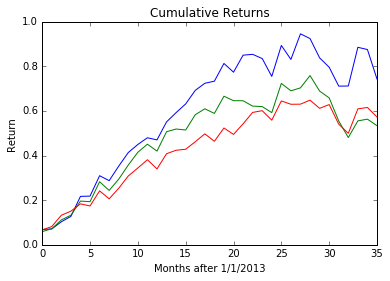

In [85]:
plt.plot(np.cumprod(ourfrets)-1)
plt.plot(np.cumprod(jegfrets)-1)
plt.plot(np.cumprod(mktfrets)-1)
plt.title('Cumulative Returns')
plt.xlabel('Months after 1/1/2013')
plt.ylabel('Return')
plt.show()

In [ ]:
# Autocorrelation

data = web.get_data_yahoo("AA", start=st, end=en)
mdata = data.resample("M").pct_change().dropna()
Y = mdata["Close"].values - np.mean(mdata["Close"].values)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(Y, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(Y, lags=40, ax=ax2)
plt.show()

In [20]:
# Out of Sample Data
dataset = sp500_tickers_joey[:]

# take list of stocks
st = dt.datetime(2010,1,1)
en = dt.datetime(2016,1,1)
#ours
regr_coef = np.array([0.25298567255645865, -0.12886536167593118, 0.019203996926985011, 0.028682508989952348, -0.0066884204332014778, -0.10153536136157984, 0.025687100756060847, -0.010705398522536751, -0.032641524657629657, -0.042552908843307105, 0.0042183541030977626, -0.044232746890859702, -0.030952224152683578, -0.014879969341961664, 0.0028323358461219473, -0.0060362359252851142])
# jegadeesh
#regr_coef = np.array([-.0923,-.0073,.0208,.0154,.0148,.0205,.0087,.0065,.0178,.0151,.0224,.0339,.0171,.0187,-.0033,.0135])
#regr_coef = -np.zeros(16)

exp_ret = np.zeros([12*3,len(dataset)])
act_ret = np.zeros([12*3,len(dataset)])

t = 0

for ticker in dataset:
    # calculate returns
    print(ticker)
    
    try:
        data = web.get_data_yahoo(ticker, start=st, end=en)
    except:
        print(ticker, "error")
        continue
    
    mdata = data.resample("M").pct_change().dropna()
    
    adj_close = mdata["Adj Close"]
      
    k = 0
    for i in range(len(adj_close)):
        if adj_close.index[i] > dt.datetime(2013,1,1):
            #print(adj_close.index[i])
            x_row = np.zeros(16) # 1-12 months, 24m, 36m, 1 constant, 1 january
            x_row[0:12] = adj_close[i-12:i].values[::-1]
            #print("The following are the x variables in the regression.")
            #print(adj_close[i-12:i][::-1])
            #print()
            #print("The following is the y in the regression.")
            #print(adj_close[i:i+1])
            #print()
            x_row[12] = adj_close[i-24]
            x_row[13] = adj_close[i-36]
            x_row[14] = 1
            if adj_close.index[i].month == 1:
                x_row[15] = 1
            
            #print("The returns above get stored in the x_row vector, matching up to the regression coefficients.")
            #print("x_row",x_row)
            #print()
            #print("k,t", k,t)
            exp_ret[k,t] = np.dot(x_row, regr_coef)
            act_ret[k,t] = adj_close[i]
            #print("expected return",exp_ret[k,t],"actual return",act_ret[k,t])
            k += 1
    
    t += 1  # count ticker    

exp_ret_df = pd.DataFrame(data=exp_ret, index=pd.date_range(start=dt.datetime(2013,1,1), end=dt.datetime(2016,1,1),freq='M'),columns = dataset)
act_ret_df = pd.DataFrame(data=act_ret, index=pd.date_range(start=dt.datetime(2013,1,1), end=dt.datetime(2016,1,1),freq='M'),columns = dataset)
#print(exp_ret_df)

dates = pd.date_range(start=dt.datetime(2013,1,1), end=dt.datetime(2016,1,1),freq='M')
frets = []
for index, row in act_ret_df.iterrows():
    sorted_row = row.order(ascending=False)
    pret = 0
    for x in range(30):
        #print(sorted_row[x], act_ret_df.loc[index,sorted_row.index[x]])
        pret += act_ret_df.loc[index,sorted_row.index[x]]
    pret = 1.0+pret/30.0
    frets.append(pret)
    print("date", index)
    #print(sorted_row[:5].index.values)
    print("period return", pret)
    print("-------")
print("avg return", np.prod(frets)-1)

AA
AAPL
ABC
ABT
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AET
AFL
AGN
AIG
AIV
AIZ
AKAM
ALL
AMAT
AMGN
AMP
AMT
AMZN
AN
ANTM
AON
APA
APC
APD
AVB
AVY
AXP
AZO
BA
BAC
BAX
BBBY
BBT
BBY
BCR
BDX
BEN
BHI
BIIB
BK
BLL
BMY
BRCM
BSX
BXP
C
CA
CAG
CAH
CAT
CB
CBG
CBS
CCE
CCL
CELG
CHK
CHRW
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMI
CMS
CNP
CNX
COF
COH
COL
COP
COST
CPB
CSCO
CSX
CTAS
CTL
CTSH
CTXS
CVS
CVX
D
DD
DE
DFS
DGX
DHI
DHR
DIS
DOV
DOW
DRI
DTE
DUK
DVN
EA
EBAY
ECL
ED
EFX
EIX
EL
EMC
EMN
EMR
EOG
EQR
ESRX
ETFC
ETN
ETR
EXC
EXPD
EXPE
F
FCX
FDX
FE
FIS
FISV
FITB
FLR
FOXA
FTR
GAS
GD
GE
GILD
GIS
GLW
GME
GOOGL
GPC
GPS
GS
GT
GWW
HAL
HAR
HAS
HBAN
HD
HES
HIG
HOG
HON
HOT
HPQ
HRB
HST
HSY
HUM
IBM
ICE
IFF
INTC
INTU
IP
IPG
ITW
JCI
JEC
JNJ
JNPR
JPM
JWN
K
KEY
KIM
KLAC
KMB
KO
KR
KSS
L
LB
LEG
LEN
LH
LLL
LLTC
LLY
LM
LMT
LNC
LOW
LUK
LUV
M
MAR
MAS
MAT
MCD
MCHP
MCK
MCO
MDLZ
MDT
MET
MHFI
MKC
MMC
MMM
MO
MON
MRK
MRO
MS
MSFT
MSI
MTB
MU
MUR
MYL
NBL
NEE
NEM
NI
NKE
NOC
NOV
NSC
NTAP
NTRS
NUE
NVDA
NWL
OMC
ORCL
OXY
PAYX
PBI
PCAR
PCG
PCL
PCP
PDCO
PEG
PEP


-c:68: FutureWarning: order is deprecated, use sort_values(...)


In [64]:
data = web.get_data_yahoo("BBY", start=st, end=en)
mdata = data.resample("M",how='last')
adj_close = mdata["Adj Close"]
print(adj_close[12*4:12*5])

Date
2013-01-31    14.617557
2013-02-28    14.752405
2013-03-31    20.066750
2013-04-30    23.545591
2013-05-31    24.958870
2013-06-30    24.912565
2013-07-31    27.428433
2013-08-31    32.815673
2013-09-30    34.338704
2013-10-31    39.191907
2013-11-30    37.131584
2013-12-31    36.667914
Freq: M, Name: Adj Close, dtype: float64
